# Packages

In [1]:
# Data and Maths
import pandas as pd
import geopandas as gpd
import numpy as np
import math
from dataclasses import dataclass

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats
from scipy.stats import binom, norm
import pymc as pm
import arviz as az
RANDOM_SEED = 42
import random

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Pre-processing

In [229]:
@dataclass
class DataContainer:
    file_path: str
    raw_data: pd.DataFrame = None
    data: pd.DataFrame = None

class BasePreprocessor():
    def __init__(self, data_container: DataContainer) -> None:
        self.data_container = data_container
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> None:
        self._load_csv_to_df(self.data_container, keep_raw, dtype, na_values)

    def _load_csv_to_df(self, container: DataContainer, keep_raw: bool, dtype=None, na_values=None) -> None:
        try:
            container.data = pd.read_csv(container.file_path, dtype=dtype, na_values=na_values)
            if keep_raw:
                container.raw_data = container.data.copy()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {container.file_path}") from e
    
    def _rename_df_columns(self, column_mapper: dict) -> None:
        self.data_container.data = self.data_container.data.rename(columns=column_mapper)

    def _select_df_columns(self, columns: list) -> None:
        self.data_container.data = self.data_container.data[columns]

    def _drop_duplicate_rows(self, subset) -> None:
        self.data_container.data.drop_duplicates(subset=subset, keep='first', inplace=True)
    
    def _drop_duplicate_rows_by_index(self) -> None:
        self.data_container.data = self.data_container.data[~self.data_container.data.index.duplicated(keep='first')]

    def _set_df_index(self, index_name: str, drop: bool) -> None:
        self.data_container.data = self.data_container.data.set_index(index_name, drop=drop)
    
    def _apply_dtypes(self, start_col: int, end_col: int) -> dict:
        dtypes = {i: str for i in range(start_col)} # first 'first' columns as strings
        dtypes.update({i: float for i in range(start_col, end_col)}) # 'last' columns is currently hard coded. Float is needed for NaNs
        return dtypes

class CarVan2011DataPreprocessor(BasePreprocessor):
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw)
        self._rename_df_columns({
            'GEO_CODE': 'LSOA11CD',
            'GEO_LABEL': 'LSOA11NM',
            'Car or van availability : Sum of all cars or vans - Unit : Cars or vans': 'cars',
            'Car or van availability : No cars or vans in household - Unit : Households': 'households_without_cars',
            'Car or van availability : Total\ Car or van availability - Unit : Households': 'households'
            }
        )
        self._drop_duplicate_rows('LSOA11CD')
        self._set_df_index('LSOA11CD', drop=True)
        self._select_df_columns(['LSOA11NM', 'cars', 'households', 'households_without_cars'])
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

class CarVan2021DataPreprocessor(BasePreprocessor):  
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 

    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw)
        self._count_number_of_cars()
        self._condense_data()
        self._reindex_data()
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

    def _count_number_of_cars(self) -> None:
        self.data_container.raw_data['cars'] = self.data_container.raw_data['Observation'] * self.data_container.raw_data['Car or van availability (5 categories) Code']

    def _condense_data(self) -> None:
        self.data_container.data = (
            pd.DataFrame(index=self.data_container.raw_data['Lower Layer Super Output Areas Code'].unique(), columns=['LSOA21CD', 'LSOA21NM', 'cars', 'houses_without_cars'])
            .assign(
                LSOA21CD=lambda df: df.index, 
                LSOA21NM=self.data_container.raw_data['Lower Layer Super Output Areas'].unique(),
                cars=self.data_container.raw_data.groupby('Lower Layer Super Output Areas Code')['cars'].sum(),
                houses_without_cars=self.data_container.raw_data.loc[self.data_container.raw_data['Car or van availability (5 categories) Code'] == 0, ['Lower Layer Super Output Areas Code', 'Observation']].set_index('Lower Layer Super Output Areas Code')
            )
        )

    def _reindex_data(self) -> None:
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        data = self.data_container.data
        self.data_container.data = (
            data
            .merge(lsoa_lookup[['LSOA11CD', 'LSOA21CD']], on='LSOA21CD', how='right')
            .assign(cars=lambda df: df.groupby('LSOA11CD')['cars'].transform('sum'))
            .drop(columns=['LSOA21CD'])
        )
        self._set_df_index('LSOA11CD', drop=True)

class VehicleRegistrationsDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer):
        super().__init__(data_container)
        self.data_container = data_container
    
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype=self._apply_dtypes(5, 57), na_values=['[c]', '[x]'])
        self.data_container.data = self._preprocess_by_bodytype('Cars') + self._preprocess_by_bodytype('Other body types')
        self._drop_duplicate_rows_by_index()
        self.data_container.data = self.data_container.data.drop('Miscellaneous')
        self.data_container.data = self.data_container.data.dropna(how='all')
        print('Pre-processing complete')
        return self.data_container.data
    
    def _preprocess_by_bodytype(self, bodytype: str) -> pd.DataFrame:
        bodytype_data = self.data_container.data.query("BodyType == '" + bodytype + "' & Keepership == 'Private' & LicenceStatus == 'Licensed'")
        bodytype_data = bodytype_data.drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM'])
        bodytype_data = bodytype_data.set_index('LSOA11CD', drop=True)
        return bodytype_data
    
class EVRegistrationsDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, fuel_type: str):
        super().__init__(data_container)
        self.data_container = data_container
        self.fuel_type = fuel_type
    
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype=self._apply_dtypes(4, 56), na_values=['[c]', '[x]'])
        self._filter_data()
        self._set_df_index('LSOA11CD', drop=True)
        self._split_by_fuel_type()
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data
    
    def _filter_data(self):
        self.data_container.data = (
            self.data_container.data
            .query("Keepership == 'Private'")
            .drop(columns=['Keepership', 'LSOA11NM'])
        )
    
    def _split_by_fuel_type(self):
        self.data_container.data = (
            self.data_container.data
            .query("Fuel == '" + self.fuel_type + "' or Fuel.isnull()")
            .drop(columns=["Fuel"])
        )

class HouseDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype, na_values)
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        self.data_container.data = (
            self.data_container.data
            .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'households'})
            .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD']], on = 'LSOA21CD', how='outer')
            .drop(columns=['LSOA21NM'])
            .set_index('LSOA11CD')
        )
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

class AccommodationTypeDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype, na_values)
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        self.data_container.data = (
            self.data_container.data
            .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Accommodation type (8 categories)':'accommodation_type'})
            .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD']], on = 'LSOA21CD', how='outer')
            .drop(columns=['LSOA21NM', 'Accommodation type (8 categories) Code'])
            .set_index('LSOA11CD')
        )
        print('Pre-processing complete')
        return self.data_container.data

In [230]:
# Create Data Containers
car_van_2011_container = DataContainer(file_path='../Data/Vehicle/CarsAndVans2011.csv')
car_van_2021_container = DataContainer(file_path='../Data/Vehicle/CarsAndVans2021.csv')
vehicle_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0125.csv')
bev_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0145.csv')
phev_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0145.csv')
house_2021_container = DataContainer(file_path='../Data/Demographic/LSOA_households.csv')
accomodation_type_2021_container = DataContainer(file_path='../Data/Demographic/LSOA_accommodation_type.csv')

# Load and preprocess data
lsoa_lookup_file = '../data/spatial/LSOA/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv'
car_van_2011_data_preprocessor = CarVan2011DataPreprocessor(car_van_2011_container)
car_van_2021_data_preprocessor = CarVan2021DataPreprocessor(car_van_2021_container, lsoa_lookup_file)
vehicle_registrations_data_preprocessor = VehicleRegistrationsDataPreprocessor(vehicle_registrations_container)
bev_registrations_data_preprocessor = EVRegistrationsDataPreprocessor(bev_registrations_container, fuel_type='Battery electric')
phev_registrations_data_preprocessor = EVRegistrationsDataPreprocessor(phev_registrations_container, fuel_type='Plug-in hybrid electric (petrol)')
house_2021_data_preprocessor = HouseDataPreprocessor(house_2021_container, lsoa_lookup_file)
accomodation_type_2021_data_preprocessor = AccommodationTypeDataPreprocessor(accomodation_type_2021_container, lsoa_lookup_file)

car_van_2011_data = car_van_2011_data_preprocessor.preprocess(keep_raw=False)
car_van_2021_data = car_van_2021_data_preprocessor.preprocess(keep_raw=True)
vehicle_registrations_data = vehicle_registrations_data_preprocessor.preprocess(keep_raw=False)
bev_registrations_data = bev_registrations_data_preprocessor.preprocess(keep_raw=True)
phev_registrations_data = phev_registrations_data_preprocessor.preprocess(keep_raw=True)
house_2021_data = house_2021_data_preprocessor.preprocess(keep_raw=False)
accomodation_type_2021_data = accomodation_type_2021_data_preprocessor.preprocess(keep_raw=False)

Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete


In [4]:
car_van_2021_data.head()

,LSOA21NM,cars,houses_without_cars
LSOA11CD,,,
E01000001,City of London 001A,331,555
E01000002,City of London 001B,296,578
E01000003,City of London 001C,220,826
E01000005,City of London 001E,119,375
E01000006,Barking and Dagenham 016A,516,183


In [5]:
vehicle_registrations_data.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
95AA01S1,136.0,134.0,135.0,142.0,155.0,146.0,146.0,158.0,162.0,159.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA01S2,1491.0,1483.0,1489.0,1516.0,1504.0,1498.0,1517.0,1533.0,1499.0,1494.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA01S3,1176.0,1167.0,1174.0,1195.0,1171.0,1151.0,1175.0,1177.0,1182.0,1199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA02W1,774.0,776.0,760.0,759.0,765.0,779.0,796.0,788.0,790.0,786.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA03W1,852.0,850.0,853.0,853.0,856.0,843.0,843.0,836.0,830.0,825.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Find Common LSOA Codes and Filter Data

In [6]:
def intersection_of_lists(*args):
    """
    Returns the intersection of all provided lists.

    Args:
    *args: Variable length argument of lists.

    Returns:
    List containing the intersection of all provided lists.
    """
    
    # If no lists are provided, return an empty list
    if not args:
        return []

    # Start with the set of the first list
    result_set = set(args[0])

    # Iterate over the remaining lists, updating the result_set
    for lst in args[1:]:
        result_set &= set(lst)

    return list(result_set)

In [7]:
accomodation_type_2021_data

,LSOA21CD,accommodation_type,Observation
LSOA11CD,,,
E01000001,E01000001,Detached,0
E01000001,E01000001,Semi-detached,3
E01000001,E01000001,Terraced,13
E01000001,E01000001,In a purpose-built block of flats or tenement,803
E01000001,E01000001,"Part of a converted or shared house, including...",0
...,...,...,...
W01001061,W01002040,In a purpose-built block of flats or tenement,198
W01001061,W01002040,"Part of a converted or shared house, including...",3
W01001061,W01002040,"Part of another converted building, for exampl...",0


In [231]:
common_lsoas = intersection_of_lists(
    car_van_2011_data.index,
    car_van_2021_data.index,
    vehicle_registrations_data.index,
    bev_registrations_data.index,
    phev_registrations_data.index,
    house_2021_data.index,
    accomodation_type_2021_data.index
)

car_van_2011_data = car_van_2011_data.loc[common_lsoas].sort_index()
car_van_2021_data = car_van_2021_data.loc[common_lsoas].sort_index()
vehicle_registrations_data = vehicle_registrations_data.loc[common_lsoas].sort_index()
bev_registrations_data = bev_registrations_data.loc[common_lsoas].sort_index()
phev_registrations_data = phev_registrations_data.loc[common_lsoas].sort_index()
house_2021_data = house_2021_data.loc[common_lsoas].sort_index()
accomodation_type_2021_data = accomodation_type_2021_data.loc[common_lsoas].sort_index()

In [232]:
vehicle_registrations_data

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,301.0,304.0,313.0,325.0,327.0,325.0,321.0,322.0,322.0,329.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01000002,270.0,274.0,268.0,269.0,274.0,278.0,274.0,280.0,288.0,288.0,...,320.0,319.0,317.0,328.0,324.0,328.0,328.0,323.0,301.0,303.0
E01000003,165.0,170.0,178.0,177.0,170.0,167.0,164.0,180.0,177.0,181.0,...,193.0,201.0,203.0,206.0,205.0,206.0,206.0,203.0,206.0,207.0
E01000005,97.0,95.0,98.0,102.0,NaN,97.0,99.0,100.0,NaN,NaN,...,NaN,NaN,NaN,115.0,119.0,NaN,NaN,NaN,NaN,NaN
E01000006,499.0,500.0,501.0,505.0,492.0,478.0,479.0,491.0,501.0,499.0,...,504.0,504.0,508.0,506.0,519.0,527.0,528.0,540.0,514.0,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W01001951,326.0,331.0,329.0,329.0,327.0,334.0,338.0,331.0,326.0,325.0,...,351.0,369.0,364.0,364.0,355.0,359.0,370.0,383.0,380.0,361.0
W01001953,701.0,684.0,689.0,684.0,686.0,695.0,698.0,691.0,678.0,683.0,...,593.0,593.0,604.0,578.0,586.0,575.0,577.0,573.0,558.0,564.0
W01001954,914.0,910.0,917.0,919.0,930.0,926.0,939.0,938.0,923.0,928.0,...,903.0,906.0,895.0,895.0,896.0,892.0,894.0,897.0,895.0,888.0


# Estimating EV Adoption in LSOAs

In [213]:
class RegistrationInterpolator:
    def __init__(self, sample_rate=4) -> None:
        self.registration_data = None
        self.sample_rate = sample_rate

    # Interpolates missing registration data
    def interpolate(self, registration_data: pd.DataFrame) -> pd.DataFrame:
        self.registration_data = registration_data.T.iloc[::-1]
        interpolated_df = self.registration_data.apply(self._interpolate_column, axis=0)
        interpolated_df = interpolated_df.fillna(0)
        interpolated_df = interpolated_df.astype('Int64')
        return interpolated_df.iloc[::-1].T
    
    def _interpolate_column(self, col) -> pd.Series:
        dates = self._calculate_date_range(self._calculate_t0(col), self._calculate_t_present(col))
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated_array = np.round(np.interp(x, xp, fp))
            interpolated_series = pd.Series(data=interpolated_array, index=col.index)
        else:
            interpolated_series = pd.Series(data=np.nan, index=col.index)
        return interpolated_series

    # apply_dtypes converts select columns from str to float values
    def _apply_dtypes(first_col: int, last_col: int) -> dict:
        dtypes = {i: str for i in range(first_col)}  # first 'first' columns as strings
        dtypes.update({i: float for i in range(first_col, last_col)}) # 'last' columns is currently hard coded. Float is needed for NaNs
        return dtypes
    
    def _quarter_to_decimal(self, year: int, quarter: str) -> float:
        """
        Converts a year and quarter to a decimal year representation.
        """
        quarters = {'Q1': 0, 'Q2': 0.25, 'Q3': 0.5, 'Q4': 0.75}
        return year + quarters.get(quarter, 0)

    def _calculate_t0(self, col) -> float:
        year = int(col.head(1).index[0][:4])
        quarter = col.head(1).index[0][-2:]
        return self._quarter_to_decimal(year, quarter)

    def _calculate_t_present(self, col) -> float:
        year = int(col.tail(1).index[0][:4])
        quarter = col.tail(1).index[0][-2:]
        return self._quarter_to_decimal(year, quarter)

    def _convert_dates_to_numeric(self) -> list:
        dates = []
        for date in self.registration_data.index:
            year = int(date[:4])
            quarter = date[-2:]
            dates.append(self._quarter_to_decimal(year, quarter))
        return dates

    # Returns an array of numeric dates between t0 and t1 at a specified sample rate
    def _calculate_date_range(self, t0: float, t1: float) -> list:
        return np.linspace(t0, t1, int((t1-t0)*self.sample_rate) + 1)

In [233]:
registration_interpolator = RegistrationInterpolator()
vehicle_registrations_data_i = registration_interpolator.interpolate(vehicle_registrations_data)
bev_registrations_data_i = registration_interpolator.interpolate(bev_registrations_data)
phev_registrations_data_i = registration_interpolator.interpolate(phev_registrations_data)

# Calculating Error and Uncertainty in Vehicle Registration Data (The quick way)

In [215]:
class VehicleRegistrationRelativeDifferenceCalculator:
    def __init__(
            self, 
            car_van_2011_data: pd.DataFrame, 
            car_van_2021_data: pd.DataFrame, 
            vehicle_registrations_data: pd.DataFrame, 
        ):
        self.car_van_2011_data = car_van_2011_data
        self.car_van_2021_data = car_van_2021_data
        self.vehicle_registrations_data = vehicle_registrations_data.astype(float)
        self.relative_difference_data = None

    def calculate(self) -> pd.DataFrame:
        self._calculate_relative_differences(2011)
        self._calculate_relative_differences(2021)
        self._merge_relative_difference_data()
        return self.relative_difference_data 

    def _calculate_mean_registered_vehicles_for_year(self, year: int) -> None:
        columns = [f"{year} {quarter}" for quarter in ['Q1', 'Q2', 'Q3', 'Q4']]
        df = getattr(self, f'car_van_{year}_data')
        df['registered_vehicles'] = self.vehicle_registrations_data.loc[:, columns].mean(axis=1).round()
    
    def _calculate_absolute_differences(self, year: int) -> None:
        df = getattr(self, f'car_van_{year}_data')
        df['abs_difference'] = df['cars'] - df['registered_vehicles']
    
    def _calculate_relative_differences(self, year: int) -> None:
        self._calculate_mean_registered_vehicles_for_year(year)
        self._calculate_absolute_differences(year)
        df = getattr(self, f'car_van_{year}_data')
        df['relative_difference'] = df['abs_difference'] / df['registered_vehicles']
    
    def _merge_relative_difference_data(self) -> None:
        relative_difference_2011_df = pd.DataFrame({'LSOA11CD': self.car_van_2011_data['relative_difference'].index, 'relative_difference_2011': self.car_van_2011_data['relative_difference'].values})
        relative_difference_2021_df = pd.DataFrame({'LSOA11CD': self.car_van_2021_data['relative_difference'].index, 'relative_difference_2021': self.car_van_2021_data['relative_difference'].values})
        self.relative_difference_data = pd.merge(relative_difference_2011_df, relative_difference_2021_df, how='outer', on='LSOA11CD').set_index('LSOA11CD')
    
class RelativeDifferenceSampleGenerator:
    def __init__(self, relative_difference_data: pd.DataFrame, n_samples: int):
        self.relative_difference_data = relative_difference_data
        self.relative_difference_samples = None
        self.n_samples = n_samples
    
    def generate_samples(self) -> pd.DataFrame:
        self._calculate_relative_difference_mu_and_sigma()
        self._calculate_relative_difference_samples()
        return self.relative_difference_samples

    def _calculate_relative_difference_mu_and_sigma(self) -> None:
        # Priors
        mu_prior = pd.concat([self.relative_difference_data['relative_difference_2011'], self.relative_difference_data['relative_difference_2021']]).mean()
        sigma_prior = pd.concat([self.relative_difference_data['relative_difference_2011'], self.relative_difference_data['relative_difference_2021']]).std()
        var_prior = sigma_prior**2
        precision_prior = 1/var_prior

        # Data
        mu_lsoa = self.relative_difference_data[['relative_difference_2011', 'relative_difference_2021']].mean(axis=1)
        sigma_lsoa = self.relative_difference_data[['relative_difference_2011', 'relative_difference_2021']].std(axis=1)
        var_lsoa = sigma_lsoa**2
        precision_lsoa = 1/var_lsoa

        # Posterior
        mu_post = (2*mu_lsoa*precision_lsoa + mu_prior*precision_prior)/(2*precision_lsoa + precision_prior)
        sigma_post = np.sqrt(1/(2*precision_lsoa + precision_prior))

        self.relative_difference_data['mu_post'] = mu_post
        self.relative_difference_data['sigma_post'] = sigma_post

        # Fill in missing data with mu_prior and sigma_prior (the mean mu and sigma for all LSOAs) if mu_post or sigma_post is NaN
        # This is a result from missing either Census and Registration data in both 2011 and 2021
        self.relative_difference_data.loc[self.relative_difference_data['mu_post'].isna(), 'mu_post'] = mu_lsoa[self.relative_difference_data['mu_post'].isna()]
        self.relative_difference_data.loc[self.relative_difference_data['mu_post'].isna(), 'mu_post'] = mu_prior
        self.relative_difference_data.loc[self.relative_difference_data['sigma_post'].isna(), 'sigma_post'] = sigma_prior

    def _calculate_relative_difference_samples(self) -> None:
        # Initialize an empty DataFrame for samples

        lsoa_list = self.relative_difference_data.index.values
        self.relative_difference_samples = pd.DataFrame(index=np.arange(0, self.n_samples), columns=lsoa_list)

        # Loop over each LSOA to generate samples
        for lsoa in lsoa_list:
            sigma = self.relative_difference_data.sigma_post.loc[lsoa]  # Assuming sigma_post is indexed by LSOA
            mu = self.relative_difference_data.mu_post.loc[lsoa]
            sample_array = np.random.normal(mu, sigma, size=self.n_samples)
            self.relative_difference_samples[lsoa] = sample_array

class VehicleRegistrationEstimator:
    def __init__(self, relative_difference_samples) -> None:
        self.relative_difference_samples = relative_difference_samples
    #     self.registration_data = registration_data
    #     self.adjusted_registration_data = None
    
    def estimate(self, registration_data: pd.DataFrame, quarter: str) -> pd.DataFrame:
        adjusted_registration_data = (1 + self.relative_difference_samples).mul(registration_data[quarter]).round(0).astype('Int64')
        return adjusted_registration_data

In [234]:
vehicle_registration_relative_difference_calculator = VehicleRegistrationRelativeDifferenceCalculator(car_van_2011_data,
                                                                                                      car_van_2021_data,
                                                                                                      vehicle_registrations_data) # Actively choosing not to use interpolated data here

relative_difference_data = vehicle_registration_relative_difference_calculator.calculate()

relative_difference_data.head()

,relative_difference_2011,relative_difference_2021
LSOA11CD,,
E01000001,NaN,0.027950
E01000002,0.369565,0.057143
E01000003,-0.117647,0.279070
E01000005,0.059829,0.202020
E01000006,-0.025540,0.059548


In [235]:
relative_difference_sample_generator = RelativeDifferenceSampleGenerator(relative_difference_data=relative_difference_data,
                                                                         n_samples=1000)

relative_difference_samples = relative_difference_sample_generator.generate_samples()

relative_difference_samples.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,0.031750,-0.036669,0.014271,0.114279,0.014799,0.087735,-0.040162,-0.058188,-0.037825,-0.046923,...,0.355122,0.314773,0.123118,0.087127,0.308890,0.223200,0.164835,0.071877,0.054426,0.462592
1,0.038041,0.144975,-0.020223,0.184744,-0.012795,0.088185,-0.049836,-0.043621,-0.045006,0.004730,...,0.096867,0.355140,0.188814,0.078282,0.154244,0.362803,0.173748,0.034969,0.108883,0.420194
2,-0.084070,0.210910,0.093294,0.121440,-0.016728,0.088054,-0.046305,-0.081982,-0.076491,-0.079672,...,0.060832,0.280377,0.078078,0.221008,0.295497,0.299913,0.177844,0.034735,0.112442,0.403297
3,-0.087972,0.176656,0.184931,0.081200,-0.017849,0.088635,-0.041705,-0.142312,-0.030421,-0.032663,...,-0.074418,0.264611,0.094423,0.024542,0.314541,0.222988,0.195689,0.129761,0.070870,0.374178
4,-0.049636,-0.045564,-0.004184,0.212223,-0.011597,0.089189,-0.029270,-0.084983,-0.022981,-0.034591,...,0.199892,0.359079,0.083168,0.166483,0.132090,0.253916,0.156277,0.082336,0.092705,0.359129


In [236]:
vehicle_registration_estimator = VehicleRegistrationEstimator(relative_difference_samples)

vehicle_registrations_data_samples = vehicle_registration_estimator.estimate(vehicle_registrations_data_i, '2023 Q1')
bev_registrations_data_samples = vehicle_registration_estimator.estimate(bev_registrations_data_i, '2023 Q1')
phev_registrations_data_samples = vehicle_registration_estimator.estimate(phev_registrations_data_i, '2023 Q1')

<Axes: >

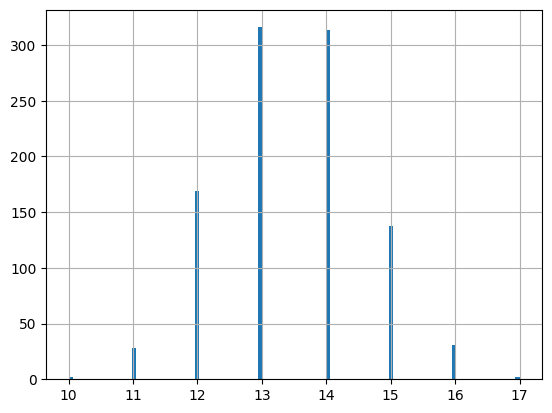

In [237]:
bev_registrations_data_samples.iloc[:, 1].hist(bins=100)

# Estimating On-Plot Parking

In [18]:
class AccommodationTypeCounter:
    def __init__(self, accommodation_type_df, houses_df):
        self.df = accommodation_type_df
        self.houses = houses_df
        self.data = None

    def count(self) -> pd.DataFrame:
        types_data = [
            self._filter_by_type('Detached', 'detached'),
            self._filter_by_type('Semi-detached', 'semi_detached'),
            self._filter_by_type('Terraced', 'terraced'),
            self._filter_by_type('In a purpose-built block of flats or tenement', 'purpose_built_flat'),
            self._combine_converted_flats()
        ]
        concatenated = pd.concat(types_data, axis=1)
        # Group by index and calculate mean (for LSOA21CDs that share a LSOA11CD)
        mean = concatenated.groupby(concatenated.index).mean()
        proportions = mean.div(mean.sum(axis=1), axis=0)
        accommodation_type_counts = round(proportions.mul(self.houses['households'], axis=0))

        # Need to drop duplicates
        self.data = accommodation_type_counts
        
        return accommodation_type_counts

    def _filter_by_type(self, accommodation_type: str, new_name: str) -> pd.Series:
        result = self.df[self.df['accommodation_type'] == accommodation_type]['Observation']
        result.name = new_name
        return result

    def _combine_converted_flats(self):
        types = [
            'Part of a converted or shared house, including bedsits',
            'Part of another converted building, for example, former school, church or warehouse',
            'In a commercial building, for example, in an office building, hotel or over a shop'
        ]
        return sum([self._filter_by_type(atype, 'converted_flat') for atype in types])

In [238]:
accommodation_type_counter = AccommodationTypeCounter(accomodation_type_2021_data, house_2021_data)
accommodation_type_counts = accommodation_type_counter.count()
accommodation_type_counts.head()

,detached,semi_detached,terraced,purpose_built_flat,converted_flat
LSOA11CD,,,,,
E01000001,0.0,3.0,13.0,804.0,18.0
E01000002,1.0,2.0,29.0,768.0,24.0
E01000003,1.0,0.0,0.0,994.0,22.0
E01000005,0.0,0.0,2.0,458.0,20.0
E01000006,34.0,88.0,284.0,121.0,27.0


In [20]:
class OnPlotParkingEstimator:
    def __init__(self, accommodation_type_counts: pd.DataFrame, n_samples: int):
        self.accommodation_type_counts = accommodation_type_counts
        self.n_samples = n_samples
        self.dict = {
            'end_terraced': 0.505,
            'mid_terraced': 0.338,
            'semi_detached': 0.822,
            'detached': 0.961,
            'converted_flat': 0.289,
            'purpose_built_flat': 0.256
            }
        self.dict['terraced'] = round(0.3765*self.dict['end_terraced'] + 0.6235*self.dict['mid_terraced'], 3)
        del self.dict['end_terraced']
        del self.dict['mid_terraced']
        self.series = pd.Series(self.dict)
        self.on_plot_parking_samples = None
    
    def estimate(self):
        # Convert series values to a 2D array with matching shape
        probabilities = self.series[self.accommodation_type_counts.columns].values[np.newaxis, :]
        
        # Generate samples for each accommodation type and LSOA using broadcasting
        samples = binom.rvs(n=self.accommodation_type_counts.values.astype(int),
                            p=probabilities,
                            size=(self.n_samples, *self.accommodation_type_counts.shape))
        
        # Sum across accommodation types (axis 2)
        summed_samples = samples.sum(axis=2)
        
        # Convert summed_samples to a DataFrame with appropriate columns and index
        on_plot_parking_df = pd.DataFrame(summed_samples, columns=self.accommodation_type_counts.index)
        
        self.on_plot_parking_samples = on_plot_parking_df
        return on_plot_parking_df

In [239]:
on_plot_parking_estimator = OnPlotParkingEstimator(accommodation_type_counts=accommodation_type_counts,
                                                   n_samples=1000)
on_plot_parking_samples = on_plot_parking_estimator.estimate()
on_plot_parking_samples.head()

LSOA11CD,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,216,224,286,124,263,350,166,241,127,230,...,166,275,626,264,169,187,363,474,619,230
1,258,208,286,116,256,362,151,242,115,235,...,180,287,627,289,154,168,390,476,638,233
2,204,205,274,128,259,353,146,237,125,239,...,175,274,606,278,160,174,377,476,627,247
3,228,212,274,130,249,364,153,238,114,247,...,195,265,634,292,171,169,397,474,633,239
4,208,196,264,121,252,371,172,249,127,252,...,182,266,625,280,181,181,375,457,615,229


In [227]:
class VehiclesWithOnPlotParkingEstimator:
    def __init__(
            self, 
            on_plot_parking_samples,
            car_van_2021_data,
            car_van_2011_data,
            house_data,
            # relative_difference_samples,
            # vehicle_registrations_data,
            ) -> None:
        
        self.on_plot_parking_samples = on_plot_parking_samples
        self.car_van_2021_data = car_van_2021_data
        self.car_van_2011_data = car_van_2011_data
        self.house_data = house_data
        # self.relative_difference_samples = relative_difference_samples
        # self.vehicle_registrations_data = vehicle_registrations_data
        
        self.houses_with_cars = None
        self.cars_per_house_with_car = None
        self.vehicles_with_on_plot_parking_samples = None
        self.proportion_of_vehicles_with_on_plot_parking = None

    def estimate(self, vehicle_registrations_data_samples: pd.DataFrame):
        """ 
        This function assumes that all on-plot parking spaces are filled before
        off-plot parking is used.
        """
        self._estimate_houses_with_cars()
        self._estimate_proportion_of_vehicles_with_on_plot_parking(vehicle_registrations_data_samples)
        return self.vehicles_with_on_plot_parking_samples
    
    def _estimate_houses_with_cars(self):
        cars = self.car_van_2021_data['cars']
        houses = self.house_data['households']
        houses_without_cars = self.car_van_2021_data['houses_without_cars']
        
        houses_with_cars = houses - houses_without_cars
        self.cars_per_house_with_car = cars / houses_with_cars
        self.houses_with_cars = houses_with_cars
    
    def _estimate_proportion_of_vehicles_with_on_plot_parking(self, vehicle_registrations_data_samples: pd.DataFrame):
        self.vehicles_with_on_plot_parking_samples = pd.DataFrame(
            np.minimum(vehicle_registrations_data_samples.values, self.on_plot_parking_samples.values), # Assumes same dimensions
            index=vehicle_registrations_data_samples.index, 
            columns=vehicle_registrations_data_samples.columns
            )
        self.proportion_of_vehicles_with_on_plot_parking = self.vehicles_with_on_plot_parking_samples.divide(vehicle_registrations_data_samples, fill_value=0).replace([np.inf, -np.inf], np.nan)

In [245]:
vehicles_with_on_plot_parking_estimator = VehiclesWithOnPlotParkingEstimator(on_plot_parking_samples=on_plot_parking_samples,
                                                                             car_van_2011_data=car_van_2011_data,
                                                                             car_van_2021_data=car_van_2021_data,
                                                                             house_data=house_2021_data)

vehicles_with_on_plot_parking_samples = vehicles_with_on_plot_parking_estimator.estimate(vehicle_registrations_data_samples=vehicle_registrations_data_samples)
vehicles_with_on_plot_parking_samples.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,216,224,167,108,263,350,166,241,127,230,...,166,275,626,264,169,187,363,474,619,230
1,258,208,162,115,256,362,151,242,115,235,...,180,287,627,289,154,168,390,476,638,233
2,204,205,180,109,259,353,146,237,125,239,...,175,274,606,278,160,174,377,476,627,247
3,228,212,196,105,249,364,153,238,114,247,...,195,265,634,292,171,169,397,474,633,239
4,208,196,164,118,252,371,172,249,127,252,...,182,266,625,280,181,181,375,457,615,229


In [247]:
proportion_of_vehicles_with_on_plot_parking_samples = vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking
proportion_of_vehicles_with_on_plot_parking_samples.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,0.694534,0.861538,1.0,1.0,0.519763,0.682261,0.491124,0.576555,0.296729,0.613333,...,0.138103,0.300875,0.430536,0.424437,0.321905,0.468672,0.444308,0.483673,0.527707,0.301837
1,0.826923,0.673139,1.0,1.0,0.519270,0.704280,0.452096,0.569412,0.270588,0.594937,...,0.184995,0.304671,0.407143,0.468395,0.332613,0.378378,0.473876,0.503171,0.517437,0.314865
2,0.739130,0.626911,1.0,1.0,0.527495,0.686770,0.434524,0.580882,0.304136,0.660221,...,0.185972,0.307865,0.434097,0.398281,0.308285,0.410377,0.456416,0.503171,0.506871,0.337893
3,0.829091,0.666667,1.0,1.0,0.508163,0.708171,0.454006,0.624672,0.264501,0.650000,...,0.237515,0.301479,0.447424,0.498294,0.324478,0.423559,0.473747,0.458858,0.531486,0.333799
4,0.727273,0.759690,1.0,1.0,0.511156,0.721790,0.502924,0.613300,0.291954,0.664908,...,0.171053,0.281481,0.445474,0.419790,0.398678,0.442543,0.462392,0.462083,0.506173,0.323446


<Axes: >

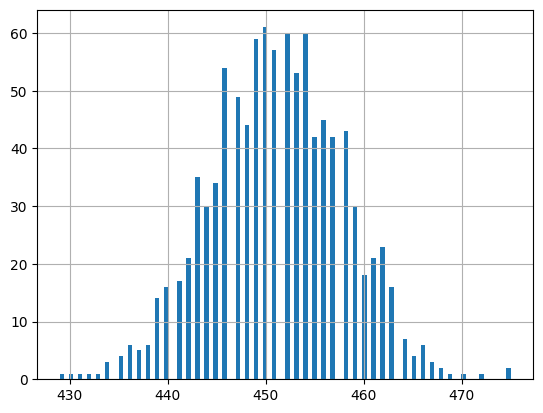

In [242]:
vehicles_with_on_plot_parking_estimator.vehicles_with_on_plot_parking_samples['E01014375'].hist(bins=100)

<Axes: >

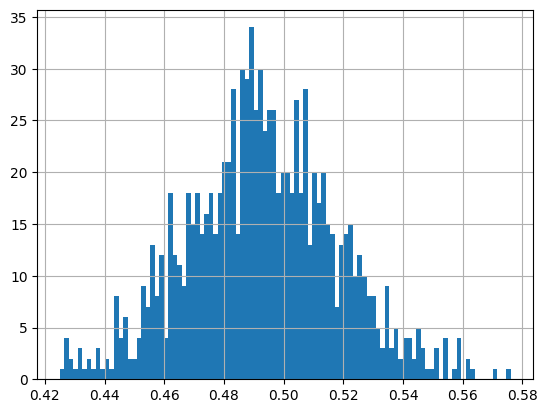

In [243]:
vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking['E01014372'].hist(bins=100)

In [248]:
class EVsWithOnPlotParkingEstimator:
    def __init__(
            self, 
            # ev_registrations_data: pd.DataFrame,
            proportion_of_vehicles_with_on_plot_parking: pd.DataFrame
            ) -> None:
        self.vehicle_registrations_data_samples = vehicle_registrations_data_samples
        # self.ev_registrations_data = ev_registrations_data
        self.relative_difference_samples = relative_difference_samples
        self.proportion_of_vehicles_with_on_plot_parking = proportion_of_vehicles_with_on_plot_parking

        self.proportion_of_evs_with_on_plot_parking = None
        self.evs_with_on_plot_parking_samples = None

    def estimate(self, ev_registrations_data_samples: pd.DataFrame):
        self._count_evs_with_on_plot_parking(ev_registrations_data_samples)
        return self.evs_with_on_plot_parking_samples

    def _calculate_proportion_of_evs_with_on_plot_parking(self, mean_total_vehicles, ev_registrations_data_samples):
        # Define alpha and beta values for beta distribution that describes likely starting points for EV on-plot parking access
        mu = 0.9 # prior mean
        var = 0.1 * mu*(1-mu)
        alpha = mu*(mu*(1-mu)/var - 1)
        beta = (1-mu)*(mu*(1-mu)/var - 1)

        c = stats.beta.rvs(a=alpha, b=beta, size=(1000, len(self.proportion_of_vehicles_with_on_plot_parking.columns))) # y intercept
        m = (self.proportion_of_vehicles_with_on_plot_parking - c)/mean_total_vehicles # gradient
        p = m*ev_registrations_data_samples + c
        return np.clip(p, a_min=0, a_max=1)
        
    def _count_evs_with_on_plot_parking(self, ev_registrations_data_samples: pd.DataFrame):
        # Return proportion of EVs with on-plot parking access. 
        # This changes depending on how many EVs there are relative to the total number of vehicles
        # It approaches the overall proportion for all vehicles.
        
        # adjusted_vehicle_registration_data_samples = (1 + self.relative_difference_samples).mul(self.vehicle_registrations_data[quarter], axis=1)
        mean_total_vehicles = self.vehicle_registrations_data_samples.mean()
        # adjusted_ev_registrations_data_samples = (1 + self.relative_difference_samples).mul(ev_registrations_data[quarter], axis=1)
        
        self.proportion_of_evs_with_on_plot_parking = self._calculate_proportion_of_evs_with_on_plot_parking(
            mean_total_vehicles, 
            ev_registrations_data_samples.sample(frac=1) # to change the order of the relative differences otherwise they cancel each other out in the next step
            )
        self.evs_with_on_plot_parking_samples = self.proportion_of_evs_with_on_plot_parking.mul(ev_registrations_data_samples, axis=1) # .round(0)
        return self.evs_with_on_plot_parking_samples

In [249]:
bevs_with_on_plot_parking_estimator = EVsWithOnPlotParkingEstimator(proportion_of_vehicles_with_on_plot_parking=proportion_of_vehicles_with_on_plot_parking_samples)

bevs_with_on_plot_parking_estimator.estimate(bev_registrations_data_samples)

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,14.629988,11.802957,8.802717,0.0,8.029489,4.143198,0.0,0.0,0.0,0.0,...,6.869056,0.0,18.477203,0.0,0.0,0.0,5.739569,11.554093,12.11081,6.45777
1,14.307096,12.47107,8.880192,0.0,7.375685,4.759992,0.0,0.0,0.0,0.0,...,4.492494,0.0,13.478603,0.0,0.0,0.0,5.906176,12.833743,13.635534,6.478053
2,13.406175,13.574419,9.092191,0.0,8.035379,4.926689,0.0,0.0,0.0,0.0,...,4.820566,0.0,17.888009,0.0,0.0,0.0,5.083108,12.447676,13.063047,6.894608
3,13.404309,12.795031,9.575276,0.0,8.406953,4.669339,0.0,0.0,0.0,0.0,...,4.748573,0.0,15.333188,0.0,0.0,0.0,5.254776,13.998913,11.411701,6.066271
4,13.744588,10.159987,8.5543,0.0,8.249723,3.84257,0.0,0.0,0.0,0.0,...,5.847939,0.0,18.63409,0.0,0.0,0.0,5.767273,11.152615,12.894479,6.395532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,14.524329,13.753754,9.620511,0.0,8.87743,4.535208,0.0,0.0,0.0,0.0,...,4.822023,0.0,17.272258,0.0,0.0,0.0,5.689661,11.702868,13.681504,5.533808
996,17.513764,13.727763,9.649281,0.0,9.870119,4.478559,0.0,0.0,0.0,0.0,...,5.656099,0.0,20.383762,0.0,0.0,0.0,5.96361,12.163321,13.623245,6.873204
997,14.389817,11.237706,8.907067,0.0,8.184895,3.960013,0.0,0.0,0.0,0.0,...,4.707407,0.0,14.325664,0.0,0.0,0.0,5.596578,13.053584,11.760313,6.329514
998,15.340588,11.790814,10.095677,0.0,9.203821,4.805664,0.0,0.0,0.0,0.0,...,4.390252,0.0,19.049204,0.0,0.0,0.0,5.063844,13.130377,13.277864,5.458637


<Axes: >

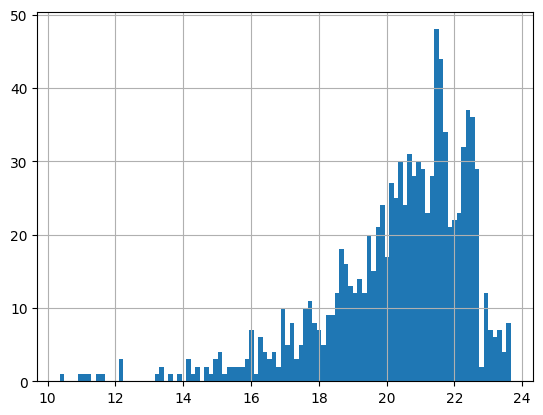

In [250]:
bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374'].hist(bins=100)

<Axes: ylabel='Density'>

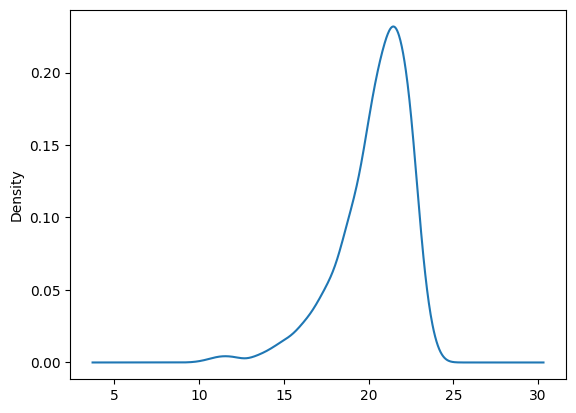

In [251]:
bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374'].plot.kde()

# Fitting Distributions to the Probabilistic Estimates

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


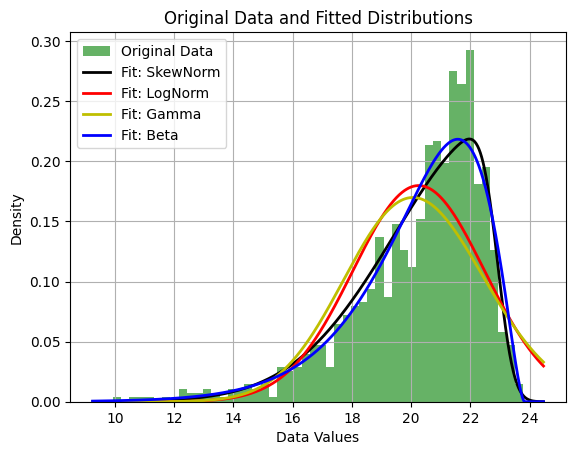

In [38]:
from scipy.stats import skewnorm, lognorm, gamma, beta

data = bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374']

params_skewnorm = skewnorm.fit(data)
params_lognorm = lognorm.fit(data)
params_gamma = gamma.fit(data)
params_beta = beta.fit(data)

plt.hist(data, bins=50, density=True, alpha=0.6, color='g', label='Original Data')

# Create an array over which you'll compute the PDFs
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

# Plot the PDFs using the parameters obtained from the fit
plt.plot(x, skewnorm.pdf(x, *params_skewnorm), 'k', linewidth=2, label='Fit: SkewNorm')
plt.plot(x, lognorm.pdf(x, *params_lognorm), 'r', linewidth=2, label='Fit: LogNorm')
plt.plot(x, gamma.pdf(x, *params_gamma), 'y', linewidth=2, label='Fit: Gamma')
plt.plot(x, beta.pdf(x, *params_beta), 'b', linewidth=2, label='Fit: Beta')

plt.legend(loc='best')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Original Data and Fitted Distributions')
plt.grid(True)
plt.show()

In [39]:
from scipy.stats import kstest

D_skewnorm, p_skewnorm = kstest(data, 'skewnorm', params_skewnorm)
D_lognorm, p_lognorm = kstest(data, 'lognorm', params_lognorm)
D_gamma, p_gamma = kstest(data, 'gamma', params_gamma)
D_beta, p_beta = kstest(data, 'beta', params_beta)

print(f"SkewNorm: D={D_skewnorm}, p={p_skewnorm}")
print(f"LogNorm: D={D_lognorm}, p={p_lognorm}")
print(f"Gamma: D={D_gamma}, p={p_gamma}")
print(f"Beta: D={D_beta}, p={p_beta}")

SkewNorm: D=0.05756410957167618, p=0.0025391357551144355
LogNorm: D=0.11618100216040622, p=3.2375655970505827e-12
Gamma: D=0.13093508856560854, p=2.0792988470512875e-15
Beta: D=0.04048258889330397, p=0.07338421916389382


### Cramér–von Mises statistic

In [40]:
import numpy as np
from scipy.stats import skewnorm

def cramer_von_mises_skewnorm(data, params):
    data_sorted = np.sort(data)
    N = len(data_sorted)
    
    # Expected CDF values under the skewed normal distribution
    cdf_theoretical = skewnorm.cdf(data_sorted, *params)
    
    # Observed ECDF values
    i = np.arange(1, N+1)
    ecdf_observed = i / N
    
    # Calculate Cramér–von Mises Statistic
    W2 = 1/12 + np.sum((ecdf_observed - cdf_theoretical)**2)
    
    return W2

params_skewnorm = skewnorm.fit(data)

W2 = cramer_von_mises_skewnorm(data, params_skewnorm)
print(f"Cramér–von Mises Statistic for Skewed Normal: {W2}")

Cramér–von Mises Statistic for Skewed Normal: 0.8537206521797505


In [41]:
import numpy as np
from scipy.stats import skewnorm, cramervonmises

def cramer_von_mises_skewnorm(data):
    # Estimate the parameters of the skewed normal distribution
    a, loc, scale = skewnorm.fit(data)

    # Apply the Cramér–von Mises test
    result = cramervonmises(data, skewnorm.cdf, args=(a, loc, scale))

    return result

data = bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374']

cvm_result = cramer_von_mises_skewnorm(data)
print(cvm_result)

CramerVonMisesResult(statistic=0.7890564324494117, pvalue=0.007756399428072713)


### Q-Q Plots

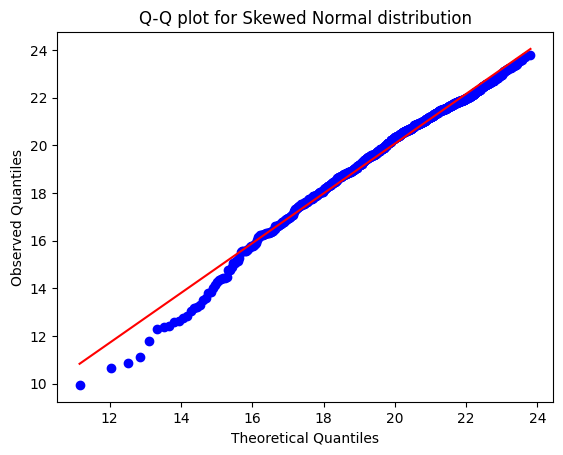

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, probplot

# Using probplot with the skewed normal distribution
osm, osr = probplot(data, dist=skewnorm, sparams=skewnorm.fit(data), plot=plt)

plt.title("Q-Q plot for Skewed Normal distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Observed Quantiles")
plt.show()

In [43]:
vehicle_registrations_data_samples['E01000119']

0      814
1      814
2      814
3      814
4      814
      ... 
995    814
996    814
997    814
998    814
999    814
Name: E01000119, Length: 1000, dtype: Int64

In [44]:
# from scipy.stats import skewnorm

# # Assuming 'vehicle_registrations_data' is your DataFrame
# # and each column represents a different LSOA with 1000 samples.

# # Create an empty DataFrame to store the parameters.
# parameters_df = pd.DataFrame(columns=['a', 'loc', 'scale'], index=vehicle_registrations_data_samples.columns)

# # Iterate over each column (LSOA) in your DataFrame.
# for i, lsoa in enumerate(vehicle_registrations_data_samples.columns):

#     print(f"{i} / {len(vehicle_registrations_data_samples.columns)} ")

#     # Get the samples for the current LSOA.
#     samples = vehicle_registrations_data_samples[lsoa].dropna().astype(float)  # Ensure there are no NaNs.

#     if samples.empty:
#         print(f"No data available for {lsoa} to fit a distribution.")
#         continue  # Skip this LSOA if there's no data.
        
#     if np.std(samples) < 1e-5:  # Some small threshold
#         print(f"Samples for LSOA {lsoa} have no variation. Skipping fitting.")
#         continue
    
#     # Fit a skewed normal distribution to the samples.
#     # 'a' is the shape parameter, 'loc' is the location (mean), and 'scale' is the scale (standard deviation).
#     a_guess = 0  # This means no skew. Adjust if you have better estimates.
#     loc_guess = samples.mean()
#     scale_guess = samples.std()
#     a, loc, scale = skewnorm.fit(samples, loc=loc_guess, scale=scale_guess)
    
#     # Store the parameters in the parameters DataFrame.
#     parameters_df.loc[lsoa] = [a, loc, scale]

# # Display the resulting DataFrame.
# print(parameters_df)

In [45]:
# from scipy.stats import skewnorm

# # Assuming 'vehicle_registrations_data_samples' is your DataFrame
# # and each column represents a different LSOA with 1000 samples.

# # Create an empty DataFrame to store the parameters.
# parameters_df = pd.DataFrame(columns=['a', 'loc', 'scale'], index=vehicle_registrations_data_samples.columns)

# # Define a function to fit the distribution.
# def fit_distribution(lsoa):
#     samples = vehicle_registrations_data_samples[lsoa].dropna().astype(float)  # Ensure there are no NaNs.

#     if samples.empty or np.std(samples) < 1e-5:
#         return lsoa, (None, None, None)
    
#     loc_guess = samples.mean()
#     scale_guess = samples.std()
#     a, loc, scale = skewnorm.fit(samples, loc=loc_guess, scale=scale_guess)
    
#     return lsoa, (a, loc, scale)

# results = []
# for i, lsoa in enumerate(vehicle_registrations_data_samples.columns):
#     print(f"{i} / {len(vehicle_registrations_data_samples.columns)} ")
#     results.append(fit_distribution(lsoa))

# # Store the results.
# for lsoa, (a, loc, scale) in results:
#     parameters_df.loc[lsoa] = [a, loc, scale]

# print(parameters_df)

# Creating LSOA Objects

In [46]:
class LSOA:
    def __init__(self) -> None:
        self.name: str
        self.gis_data: GISData
        self.params: LSOAParams

class GISData:
    def __init__(self) -> None:
        self.latitude:float
        self.longitude:float
        self.boundaries:list[GISBoundary]

class GISBoundary:
    def __init__(self) -> None:
        self.latitudes:list[float]
        self.longitudes:list[float]

class LSOAParams:
    def __init__(self) -> None:
        self.households: str
        self.accommodation_type: dict
        self.on_plot_parking: DataValue
        self.vehicles: DataValue
        self.bevs: DataValue
        self.phevs: DataValue
        self.bevs_with_on_plot_parking: DataValue
        self.phevs_with_on_plot_parking: DataValue

class DataValue:
    def __init__(self) -> None:
        self.mean: float
        self.std: float

# Mapping LSOAs Information to Selected Distribution Substations

### Load LSOA Boundary Data

In [50]:
lsoa_boundaries = gpd.read_file('../Data/Spatial/LSOA/LSOA_2011_EW_BFC_V3_WGS84/LSOA_2011_EW_BFC_V3_WGS84.shp')
lsoa_boundaries.head()

,LSOA11CD,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,GlobalID,geometry
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,2635.767993,eaf9e4b8-fcc1-4cae-a46c-22c8a43ff39b,"POLYGON ((-0.09667 51.52027, -0.09666 51.52025..."
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,2707.881853,4434ca6e-e270-4e88-b3eb-4cfb37f62490,"POLYGON ((-0.08969 51.52069, -0.08973 51.52057..."
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,1224.638192,d0ff9760-86dc-40da-ad33-3b1dc987ef04,"POLYGON ((-0.09653 51.52295, -0.09647 51.52282..."
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,2275.805348,474caa9f-a6e3-4de2-8bc1-2f5b0da40271,"POLYGON ((-0.07571 51.51575, -0.07542 51.51555..."
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,1966.092607,ff2bc9a6-9e26-4415-9cec-eaea2c0a4f54,"POLYGON ((0.09122 51.53905, 0.09148 51.53890, ..."


In [54]:
lsoa_boundaries = lsoa_boundaries.set_index('LSOA11CD')
lsoa_boundaries = lsoa_boundaries.loc[common_lsoas].sort_index()
lsoa_boundaries.head()

,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,GlobalID,geometry
LSOA11CD,,,,,,,,
E01000001,City of London 001A,532123,181632,-0.097140,51.5182,2635.767993,eaf9e4b8-fcc1-4cae-a46c-22c8a43ff39b,"POLYGON ((-0.09667 51.52027, -0.09666 51.52025..."
E01000002,City of London 001B,532480,181715,-0.091970,51.5188,2707.881853,4434ca6e-e270-4e88-b3eb-4cfb37f62490,"POLYGON ((-0.08969 51.52069, -0.08973 51.52057..."
E01000003,City of London 001C,532239,182033,-0.095320,51.5217,1224.638192,d0ff9760-86dc-40da-ad33-3b1dc987ef04,"POLYGON ((-0.09653 51.52295, -0.09647 51.52282..."
E01000005,City of London 001E,533581,181283,-0.076270,51.5147,2275.805348,474caa9f-a6e3-4de2-8bc1-2f5b0da40271,"POLYGON ((-0.07571 51.51575, -0.07542 51.51555..."
E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,1966.092607,ff2bc9a6-9e26-4415-9cec-eaea2c0a4f54,"POLYGON ((0.09122 51.53905, 0.09148 51.53890, ..."


### Load Distribution Substation Data

In [47]:
ds = (
    pd.read_csv('../Data/DistributionNetwork/distribution_substations.csv')
    .drop(
        columns = [
            'Transformer Headroom', 'LCT Count Total', 'Energy Storage', 'Heat Pumps', 
            'Total LCT Capacity', 'Total Generation Capacity', 'Solar', 
            'Wind', 'Bio Fuels', 'Water Generation', 'Waste Generation',
            'Storage Generation', 'Fossil Fuels', 'Other Generation']
    )
    .replace('Hidden', np.nan)
    .astype({'Customers':'float64', 'Substation Number':'Int64'})
    .astype({'Substation Number': str})
)
ds.head()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_23846/476462489.py:2: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../Data/DistributionNetwork/distribution_substations.csv')


,index,License Area,Grid Supply Point Number,Grid Supply Point Name,Bulk Supply Point Number,Bulk Supply Point Name,Primary Name,Primary Number,HV Feeder,Substation Type,Substation Name,Substation Number,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers
0,0,South West,306004,Abham S.G.P.,330006,Plympton Bsp,Linketty Lane,330029,330029/0016,Grd Mtd,Burniston Close 47,331299,SX553570552680,-4.035800,50.379400,189.0,78.0,500.0,0,115.0
1,1,South West,306004,Abham S.G.P.,330003,Plymouth Bsp,Plymstock South,330037,330037/0017,Grd Mtd,Furland Close,332445,SX504350522380,-4.103733,50.350925,88.0,46.0,1000.0,0,59.0
2,2,South West,306004,Abham S.G.P.,330003,Plymouth Bsp,Plymstock South,330037,330037/0018,Grd Mtd,Staddon Park,331216,SX513550525160,-4.090900,50.353700,184.0,106.0,500.0,2,149.0
3,4,South West,306004,Abham S.G.P.,330006,Plympton Bsp,Linketty Lane,330029,330029/0016,Grd Mtd,St Maurice Road,331196,SX548280554220,-4.043300,50.380700,286.0,121.0,500.0,0,178.0
4,5,South West,406003,Landulph S.G.P.,330001,Ernesettle Bsp,Southway,330023,330023/0046,Grd Mtd,Birch Valley Plastic,333252,SX513960603110,-4.093400,50.423700,746.0,453.0,1000.0,2,27.0


In [48]:
ds_geo = (
    gpd.read_file('../Data/DistributionNetwork/dist_swest_march2023.gpkg')
    .rename(columns={'NR':'Substation Number'})
    .dissolve('Substation Number').reset_index()
    .merge(ds, how='left', on ='Substation Number')
    .rename(columns={'Substation Name':'Name'})
    .fillna(value={'Discount':'Unknown'}) # For the "key_on" part of the choropleth map
    .to_crs('EPSG:4326')
)

ds_geo['Location'] = gpd.GeoSeries(gpd.points_from_xy(ds_geo.LONGITUDE, ds_geo.LATITUDE, crs="EPSG:4326"))

ds_geo.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers,Location
0,110001,"MULTIPOLYGON (((-2.58570 51.47167, -2.58578 51...",33447,19,Chesterfield Rd Id,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Chesterfield Rd Id,ST596270749730,-2.5827,51.4722,568.0,343.0,750.0,6,367.0,POINT (-2.58270 51.47220)
1,110002,"MULTIPOLYGON (((-2.59002 51.47053, -2.59028 51...",33449,19,Effingham Road Id,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Effingham Road Id,ST591950749860,-2.5889,51.4723,458.0,275.0,750.0,4,331.0,POINT (-2.58890 51.47230)
2,110003,"POLYGON ((-2.59156 51.47416, -2.59154 51.47425...",33451,19,Somerville Rd,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Somerville Rd,ST590740753250,-2.5907,51.4753,10.0,4.0,250.0,4,254.0,POINT (-2.59070 51.47530)
3,110003,"POLYGON ((-2.59156 51.47416, -2.59154 51.47425...",33451,19,Somerville Rd,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Somerville Rd,ST590740753250,-2.5907,51.4753,0.0,0.0,500.0,NaN,NaN,POINT (-2.59070 51.47530)
4,110004,"MULTIPOLYGON (((-2.58898 51.47610, -2.58895 51...",33453,19,Kent Road P,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Kent Road P,ST593560755280,-2.5867,51.4772,607.0,320.0,750.0,3,276.0,POINT (-2.58670 51.47720)


### Identify Target Substation

In [70]:
target_ds = random.choice(ds_geo['Substation Number'].values) # '110055' '160038'
target_ds

'331758'

In [343]:
ds_geo[ds_geo['Substation Number'] == target_ds]

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers,Location
29861,331758,"MULTIPOLYGON (((-4.03668 50.38933, -4.03682 50...",3773,19,Hemerdon Heights 66,305,Langage,217,Plympton Bsp,136,...,Hemerdon Heights 66,SX552750567480,-4.0375,50.3927,238.0,112.0,500.0,1,131.0,POINT (-4.03750 50.39270)


### Find Parent LSOAs

In [72]:
def find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries):
    intersections = lsoa_boundaries.geometry.intersection(ds_geo[ds_geo['Substation Number'] == target_ds].geometry.values[0])
    pip_mask = ~intersections.is_empty
    parent_lsoas = lsoa_boundaries[pip_mask].index.values
    return parent_lsoas, intersections

In [344]:
find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0]

array(['E01015110', 'E01015119', 'E01015124'], dtype=object)

In [74]:
lsoa_boundaries.loc[find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0]]

,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,GlobalID,geometry
LSOA11CD,,,,,,,,
E01015110,Plymouth 018B,255631,56578,-4.03237,50.3913,3901.522004,57550ddc-94a8-41ff-ba89-a47e99fc7315,"POLYGON ((-4.03117 50.39349, -4.03101 50.39348..."
E01015119,Plymouth 018D,255443,56942,-4.03515,50.3945,3982.776492,5825a824-e299-45a7-b04d-ed7619e8794d,"POLYGON ((-4.04019 50.39756, -4.03958 50.39748..."
E01015124,Plymouth 015D,254625,56687,-4.04655,50.3920,5815.640974,35a0d49c-b4f2-4f3b-bda1-d20c1316172e,"POLYGON ((-4.04518 50.39820, -4.04459 50.39788..."


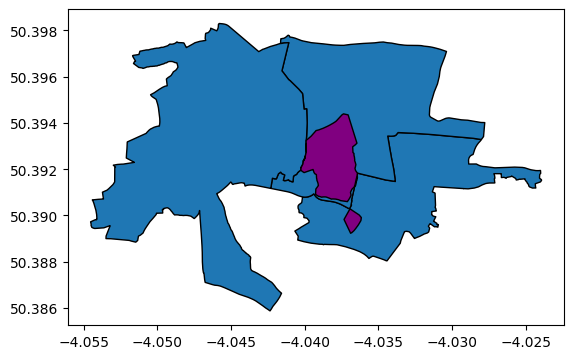

In [75]:
fig, ax = plt.subplots()
lsoa_boundaries.loc[find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0]].plot(ax=ax, edgecolor='k')
find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1].loc[find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0]].plot(ax=ax, color='purple', edgecolor='k')
plt.show()

### Calculate the proportion of distribution substation area that overlaps with the parent LSOAs

In [76]:
def calculate_relative_intersection(target_ds, ds_geo, parent_lsoas, intersections):
    return intersections.loc[parent_lsoas].area / ds_geo[ds_geo['Substation Number'] == target_ds].iloc[0].geometry.area

In [77]:
calculate_relative_intersection(target_ds, ds_geo, find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0], find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1])

LSOA11CD
E01015110    0.070135
E01015119    0.929860
E01015124    0.000005
dtype: float64

### Number of households (customers) in each of the parent LSOAs

In [309]:
house_2021_data.loc[find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0]].households

LSOA11CD
E01015110    608
E01015119    638
E01015124    680
Name: households, dtype: int64

### Total number of customers connected to the distribution substation.

In [345]:
def return_ds_customers(target_ds, ds_geo):
    ds_customers = ds_geo[ds_geo['Substation Number'] == target_ds].iloc[0].Customers
    if math.isnan(ds_customers):
        ds_customers = 0
    return ds_customers

In [346]:
return_ds_customers(target_ds, ds_geo)

131.0

### Approximate number of distribution substation customers that are located in each parent LSOA.

In [82]:
def calculate_ds_customers_in_lsoas(target_ds, ds_geo, parent_lsoas, intersections):
    relative_intersection = calculate_relative_intersection(target_ds, ds_geo, parent_lsoas, intersections)
    ds_customers = return_ds_customers(target_ds, ds_geo)
    return relative_intersection * ds_customers

In [347]:
calculate_ds_customers_in_lsoas(target_ds, ds_geo, find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0], find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1])

LSOA11CD
E01015110      9.187710
E01015119    121.811604
E01015124      0.000686
dtype: float64

### Approximate number of households in each parent LSOA that are connected to the target distribution substation.

In [84]:
def calculate_household_intersection(target_ds, ds_geo, parent_lsoas, intersections, house_2021_data):
    ds_customers_in_lsoas = calculate_ds_customers_in_lsoas(target_ds, ds_geo, parent_lsoas, intersections)
    households = house_2021_data.loc[parent_lsoas].households
    return ds_customers_in_lsoas.divide(households)

In [348]:
calculate_household_intersection(target_ds, ds_geo, find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0], find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1], house_2021_data)

LSOA11CD
E01015110    0.015111
E01015119    0.190927
E01015124    0.000001
dtype: float64

### Allocate Vehicles from LSOAs to DS

In [349]:
def allocate_data_from_lsoa_to_ds(data, lsoa_boundaries, target_ds, ds_geo, house_2021_data, parent_lsoas, intersections):

    data_filtered = data[lsoa_boundaries.loc[parent_lsoas].index]
    household_intersection = calculate_household_intersection(target_ds, ds_geo, parent_lsoas, intersections, house_2021_data)

    data_from_lsoas = []
    for lsoa in parent_lsoas: # For each intersecting LSOA
        data_from_lsoas.append(binom.rvs(n=data_filtered[lsoa].astype(int), p=household_intersection.loc[lsoa], size=(1, 1000)))

    data_from_lsoas = np.add.reduce(data_from_lsoas).flatten()

    return data_from_lsoas

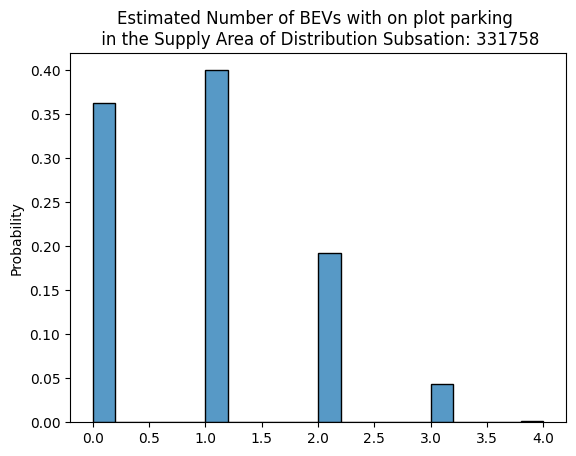

In [90]:
sns.histplot(
    allocate_data_from_lsoa_to_ds(
        data = bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples,
        lsoa_boundaries=lsoa_boundaries, 
        target_ds=target_ds,
        ds_geo=ds_geo, 
        house_2021_data=house_2021_data, 
        parent_lsoas=find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0], 
        intersections=find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1]
    ), 
    stat='probability', 
    bins=20
)
plt.title('Estimated Number of BEVs with on plot parking \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

In [427]:
ds_bevs = allocate_data_from_lsoa_to_ds(
    data=bev_registrations_data_samples,
    lsoa_boundaries=lsoa_boundaries, 
    target_ds=target_ds,
    ds_geo=ds_geo, 
    house_2021_data=house_2021_data, 
    parent_lsoas=find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[0], 
    intersections=find_parent_lsoas(target_ds, ds_geo, lsoa_boundaries)[1]
)

ds_bevs.mean()

1.1

# Experimenting with Data Compression / Data Fitting

In [452]:
jittered_data = ds_bevs + np.random.uniform(0, 1, size=ds_bevs.shape)

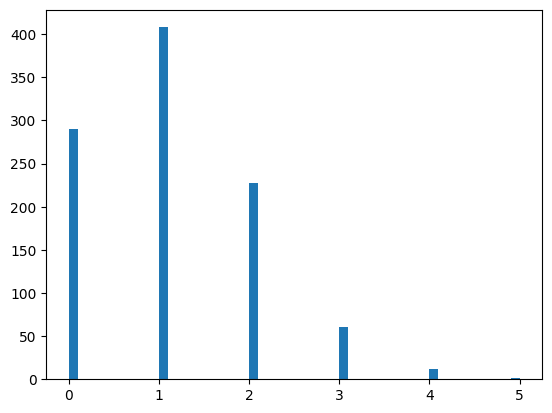

In [453]:
plt.hist(ds_bevs, bins=50)
plt.show()

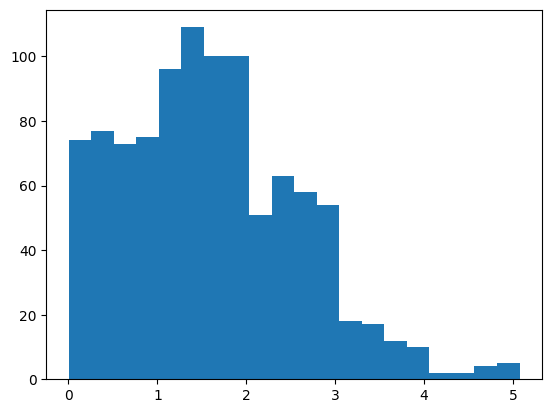

In [454]:
plt.hist(jittered_data, bins=20)
plt.show()

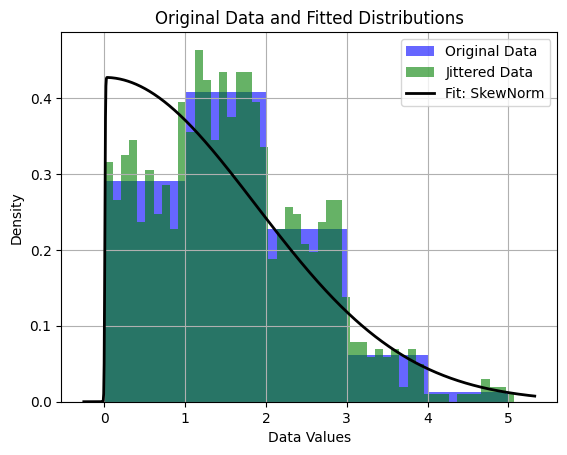

In [455]:
plt.hist(ds_bevs, bins=len(np.unique(ds_bevs))-1, density=True, alpha=0.6, color='b', label='Original Data')
plt.hist(jittered_data, bins=50, density=True, alpha=0.6, color='g', label='Jittered Data')

params_skewnorm = skewnorm.fit(jittered_data)

# Create an array over which you'll compute the PDFs
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

# Plot the PDFs using the parameters obtained from the fit
plt.plot(x, skewnorm.pdf(x, *params_skewnorm), 'k', linewidth=2, label='Fit: SkewNorm')

plt.legend(loc='best')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Original Data and Fitted Distributions')
plt.grid(True)
plt.show()

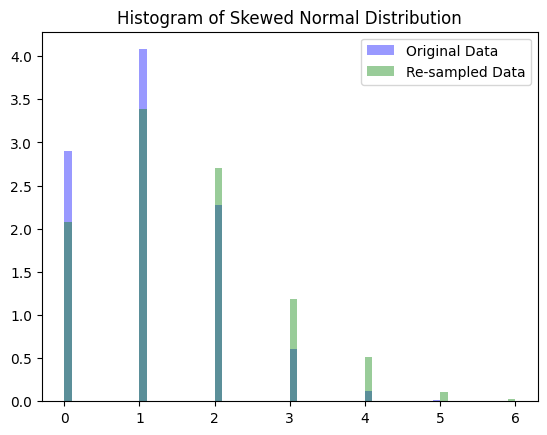

In [457]:
# Number of samples you wish to generate
num_samples = 1000

samples = skewnorm.rvs(*params_skewnorm, size=num_samples).round(0).astype(int)

# Plot histogram to visualize the skewed distribution
plt.hist(ds_bevs, bins=50, density=True, alpha=0.4, color='b', label='Original Data')
plt.hist(samples, bins=60, density=True, alpha=0.4, color='g', label='Re-sampled Data')
plt.legend(loc='best')
plt.title('Histogram of Skewed Normal Distribution')
plt.show()

In [425]:
skewnorm.fit(jittered_data)

(17073721.44530633, 0.0002861389259918741, 1.8180115620662454)

In [368]:
ds_bevs.std()

0.9209972855551747

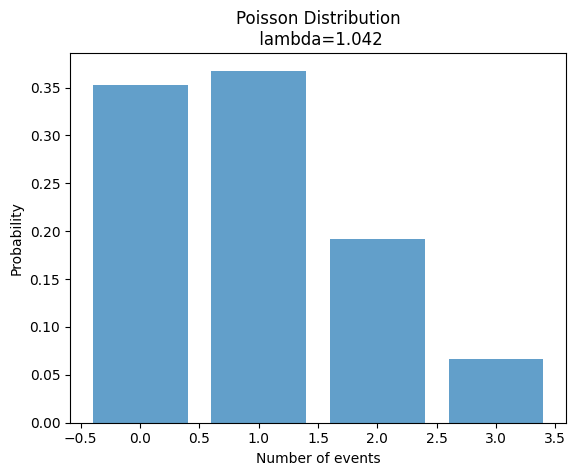

In [405]:
from scipy.stats import poisson
# Parameter
lambda_val = ds_bevs.mean()  # average rate of value

# Values
x = np.arange(0, 2*lambda_val+1)  # typically sufficient range for plotting
y = poisson.pmf(x, lambda_val)

# Plot
plt.bar(x, y, align='center', alpha=0.7)
plt.xlabel('Number of events')
plt.ylabel('Probability')
plt.title(f'Poisson Distribution\n lambda={lambda_val}')
plt.show()

# Creating a list of substation objects

In [392]:
from enum import Enum

class DistSubstation:
    def __init__(self) -> None:
        self.name:str
        self.id:str # str instead of int (for now)
        self.gisData:GISData
        self.vehicles:Vehicles
        self.evDemands:EVDemands
        self.params:SubstationParams

class SubstationParams:
    def __init__(self) -> None:
        self.numCustomers:int
        self.parentLSOAs:list

class GISData:
    def __init__(self) -> None:
        self.latitude:float
        self.longitude:float
        self.boundaries:gpd.GeoSeries

class Vehicles:
    def __init__(self) -> None:
        self.vehicles:DataValue
        self.bevs:DataValue
        self.phevs:DataValue
        self.bevsWithOnPlotParking:DataValue
        self.phevsWithOnPlotParking:DataValue

class EVDemands:
    def __init__(self) -> None:
        self.evDemandList:list[EVDemand]

class Quarter(Enum):
    Q1=0
    Q2=1
    Q3=2
    Q4=3

class EVDemand:
    def __init__(self) -> None:
        self.bev:DataValue
        self.phev:DataValue
        self.year:int
        self.quarter:Quarter

class DataValue:
    def __init__(self) -> None:
        self.a:float = 0 # skewness parameter
        self.loc:float = 0 # location parameter (similar to mean)
        self.scale:float = 0 # scale parameter (similar to std)

In [159]:
def create_substation_object(ds_geo, substation_number):
    substation = DistSubstation()
    data = ds_geo[ds_geo['Substation Number'] == substation_number]
    substation.name = data['Name'].values[0]
    substation.id = data['Substation Number'].values[0]

    gis_data = GISData()
    gis_data.latitude = data['LATITUDE'].values[0]
    gis_data.longitude = data['LONGITUDE'].values[0]
    gis_data.boundaries = data['geometry'].values[0]
    substation.gisData = gis_data

    params = SubstationParams()
    params.numCustomers = data['Customers'].values[0]
    substation.params = params

    return substation

# Wrapping this in a SubstationDataMapper Class

This class should recieve a list of substation objects, and return them with the empty attributes filled in.

In [397]:
class SubstationDataMapper:
    def __init__(self, ds_data: pd.DataFrame, lsoa_boundaries: gpd.GeoDataFrame, house_data: pd.DataFrame) -> None:
        self.ds_data = ds_data
        self.lsoa_boundaries = lsoa_boundaries
        self.house_data = house_data
        self.substation = None

    def map_to_substation(self, substation: object, data: dict):
        parent_lsoas, intersections = self._find_parent_lsoas(substation)

        vehicles_instance = Vehicles()

        vehicles_instance.vehicles = self._allocate_data_from_lsoa_to_ds(data['vehicles'], substation, parent_lsoas, intersections)
        vehicles_instance.bevs = self._allocate_data_from_lsoa_to_ds(data['bevs'], substation, parent_lsoas, intersections)
        vehicles_instance.phevs = self._allocate_data_from_lsoa_to_ds(data['phevs'], substation, parent_lsoas, intersections)
        vehicles_instance.bevsWithOnPlotParking = self._allocate_data_from_lsoa_to_ds(data['bevsWithOnPlotParking'], substation, parent_lsoas, intersections)
        vehicles_instance.phevsWithOnPlotParking = self._allocate_data_from_lsoa_to_ds(data['phevsWithOnPlotParking'], substation, parent_lsoas, intersections)

        substation.vehicles = vehicles_instance 

    def _find_parent_lsoas(self, substation: object):
        intersections = self.lsoa_boundaries.geometry.intersection(self.ds_data[self.ds_data['Substation Number'] == substation.id].geometry.values[0])
        pip_mask = ~intersections.is_empty
        parent_lsoas = self.lsoa_boundaries[pip_mask].index.values
        return parent_lsoas, intersections

    def _allocate_data_from_lsoa_to_ds(self, data: pd.DataFrame, substation: object, parent_lsoas: list, intersections):
        data_filtered = data[parent_lsoas]
        household_intersection = self._calculate_household_intersection(substation, parent_lsoas, intersections)

        data_from_lsoas = np.empty(shape=(len(parent_lsoas), 1000)) # replace 1000 with samples variable
        for i, lsoa in enumerate(parent_lsoas):  # For each intersecting LSOA
            data_from_lsoas[i] = binom.rvs(n=data_filtered[lsoa].astype(int), p=household_intersection.loc[lsoa], size=(1, 1000))
        data_from_lsoas = np.add.reduce(data_from_lsoas).flatten()

        # Estimate skewed normal parameters
        a, loc, scale = skewnorm.fit(data_from_lsoas)
        data_value = DataValue()
        data_value.a = a # skewness parameter
        data_value.loc = loc # location parameter (similar to mean)
        data_value.scale = scale # scale parameter (similar to std)

        return data_value

    def _calculate_household_intersection(self, substation: object, parent_lsoas: list, intersections):
        ds_customers_in_lsoas = self._calculate_ds_customers_in_lsoas(substation, parent_lsoas, intersections)
        households = self.house_data.loc[parent_lsoas].households
        return ds_customers_in_lsoas.divide(households)

    def _calculate_ds_customers_in_lsoas(self, substation: object, parent_lsoas: list, intersections):
        relative_intersections = self._calculate_relative_intersection(substation, parent_lsoas, intersections)
        return relative_intersections * substation.params.numCustomers

    def _calculate_relative_intersection(self, substation: object, parent_lsoas: list, intersections):
        intersection_areas = intersections.loc[parent_lsoas].area
        substation_area = self.ds_data[self.ds_data['Substation Number'] == substation.id].iloc[0].geometry.area
        return intersection_areas / substation_area

In [259]:
quarter = '2023 Q1'

# Vehicle Registrations
vehicle_registration_estimator = VehicleRegistrationEstimator(relative_difference_samples)
vehicle_registrations_data_samples = vehicle_registration_estimator.estimate(vehicle_registrations_data_i, quarter)
bev_registrations_data_samples = vehicle_registration_estimator.estimate(bev_registrations_data_i, quarter)
phev_registrations_data_samples = vehicle_registration_estimator.estimate(phev_registrations_data_i, quarter)

# EVs with On Plot Parking
evs_with_on_plot_parking_estimator = EVsWithOnPlotParkingEstimator(proportion_of_vehicles_with_on_plot_parking_samples)
bevs_with_on_plot_parking_samples = evs_with_on_plot_parking_estimator.estimate(bev_registrations_data_samples)
phevs_with_on_plot_parking_samples = evs_with_on_plot_parking_estimator.estimate(phev_registrations_data_samples)

# proportion_of_vehicles_with_on_plot_parking_samples is assumed to be stationary and can therefore be precomputed

In [398]:
substation = create_substation_object(ds_geo=ds_geo, substation_number='331758')

substation_data_mapper = SubstationDataMapper(
    ds_data=ds_geo,
    lsoa_boundaries=lsoa_boundaries,
    house_data=house_2021_data
)

substation_data_mapper.map_to_substation(substation=substation,
                                        data = {
                                            'vehicles': vehicle_registrations_data_samples, 
                                            'bevs': bev_registrations_data_samples,
                                            'phevs': phev_registrations_data_samples,
                                            'bevsWithOnPlotParking': bevs_with_on_plot_parking_samples,
                                            'phevsWithOnPlotParking': phevs_with_on_plot_parking_samples
                                        }
)

FitError: Optimization converged to parameters that are outside the range allowed by the distribution.

In [391]:
substation.vehicles.bevs.mean

1.036

In [367]:
substation.vehicles.bevs.std

0.9352988827107622